# Session 4 — Paragraph-Level Analysis
## Measure 2: Topic Drift Between Paragraphs in Tolstoy's Works

In this notebook, you will:
- represent each paragraph from **Anna Karenina** and **War and Peace** as a MiniLM embedding
- compute cosine similarity between consecutive paragraphs
- interpret low similarity as strong narrative shifts or changes in philosophical focus
- connect this to how LLM systems segment massive historical novels
  into chunks for retrieval and long-context reasoning.


In [18]:
import re
from typing import List
import numpy as np
import matplotlib.pyplot as plt

# You may need to install this once in your environment:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def load_book(filepath: str) -> str:
    """Load and lightly clean a book text (Project Gutenberg style)."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"Error: Could not find file at {filepath}")
        return ""

    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

# Loading texts from the ../data/ directory
anna_text = load_book('../data/The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt')
war_text = load_book('../data/The Project Gutenberg eBook of War and Peace, by Leo Tolstoy.txt')

print(f"Anna Karenina characters: {len(anna_text):,}")
print(f"War and Peace characters: {len(war_text):,}")

Anna Karenina characters: 1,963,419
War and Peace characters: 3,203,378


In [19]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_paras = re.split(r'\n\s*\n+', text)
    paras = []
    for p in raw_paras:
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)
    return paras

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1:
        a = a.reshape(-1)
    if b.ndim > 1:
        b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

def topic_drift_embeddings(paragraphs: List[str]) -> list:
    """Compute cosine similarity between consecutive paragraph embeddings.

    Low similarity = big topic shift (high drift).
    High similarity = smooth continuation.
    """
    if not paragraphs:
        return []
    para_embs = model.encode(paragraphs)
    sims = []
    for i in range(len(para_embs) - 1):
        sims.append(cosine_similarity(para_embs[i], para_embs[i+1]))
    return sims

anna_paras = split_into_paragraphs(anna_text)
war_paras = split_into_paragraphs(war_text)

print("Processing Anna Karenina embeddings...")
anna_drift = topic_drift_embeddings(anna_paras)

print("Processing War and Peace embeddings (this may take a moment)...")
war_drift = topic_drift_embeddings(war_paras)

print(f"Anna Karenina mean similarity: {sum(anna_drift)/len(anna_drift):.3f}")
print(f"War and Peace mean similarity: {sum(war_drift)/len(war_drift):.3f}")

Processing Anna Karenina embeddings...
Processing War and Peace embeddings (this may take a moment)...
Anna Karenina mean similarity: 0.393
War and Peace mean similarity: 0.402


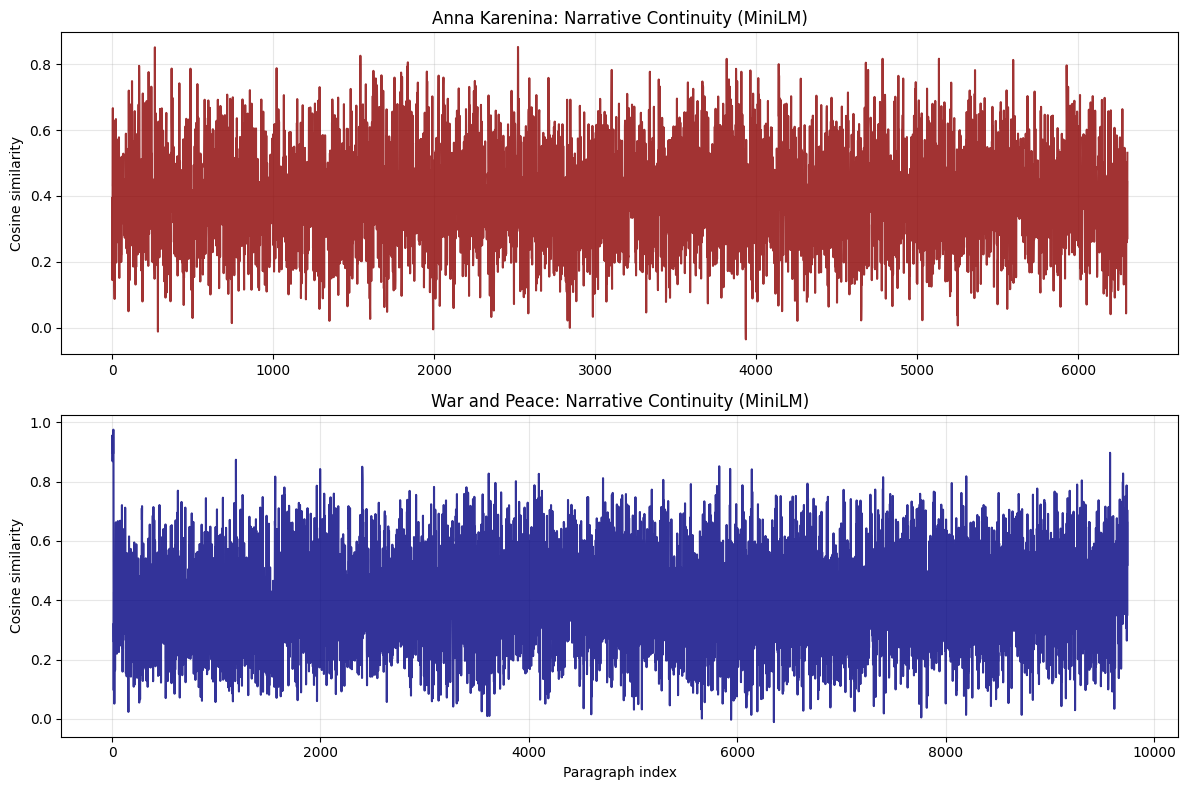

In [20]:
# Visualize topic drift as a line plot (similarity index)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

axes[0].plot(anna_drift, alpha=0.8, color='darkred')
axes[0].set_title('Anna Karenina: Narrative Continuity (MiniLM)')
axes[0].set_ylabel('Cosine similarity')
axes[0].grid(True, alpha=0.3)

axes[1].plot(war_drift, alpha=0.8, color='navy')
axes[1].set_title('War and Peace: Narrative Continuity (MiniLM)')
axes[1].set_xlabel('Paragraph index')
axes[1].set_ylabel('Cosine similarity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

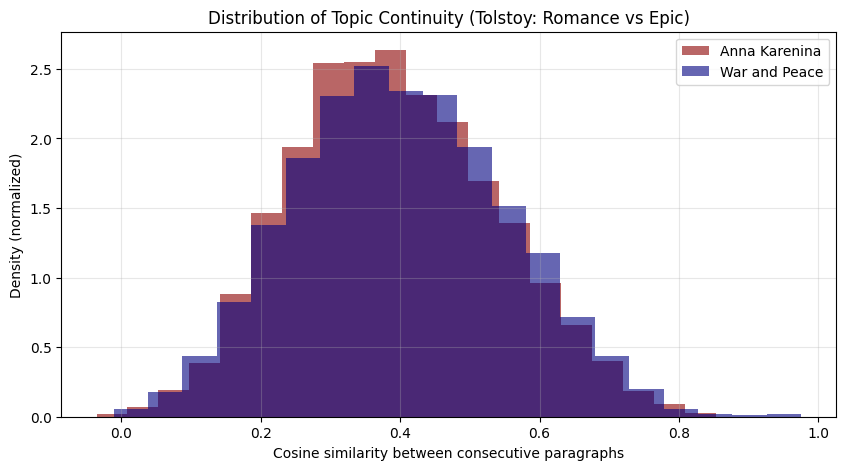

In [21]:
# Histogram comparison
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(anna_drift, bins=20, alpha=0.6, label='Anna Karenina', density=True, color='darkred')
ax.hist(war_drift, bins=20, alpha=0.6, label='War and Peace', density=True, color='navy')
ax.set_xlabel('Cosine similarity between consecutive paragraphs')
ax.set_ylabel('Density (normalized)')
ax.set_title('Distribution of Topic Continuity (Tolstoy: Romance vs Epic)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [22]:
import gc

# Delete large variables to free memory
try:
    del anna_text, war_text
    del anna_paras, war_paras
    del anna_drift, war_drift
    del model
except NameError:
    pass

# Clear matplotlib figures
plt.close('all')

# Force garbage collection
gc.collect()

print("Memory cleaned! Large variables deleted and garbage collected.")

Memory cleaned! Large variables deleted and garbage collected.
